## Import required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import statistics as st
from utils import calculate_average, Performance_metrics, Scatter_Violin_Plots
import ast

## Import Datasets

Import the mean-flow independent evaluation dataset gathered from eHydro surveys available at [here](https://www.sam.usace.army.mil/Missions/Spatial-Data-Branch/eHydro/) and [here](https://www.arcgis.com/apps/dashboards/4b8f2ba307684cf597617bf1b6d2f85d).

In [2]:
df_IE_mf = pd.read_csv('./ModelIndependentEvaluation/df_IE_mf.csv', low_memory= False)
df_IE_mf.rename(columns={"average_width_m": "mf_width_obs", "mean_depth_m": "mf_depth_obs"}, inplace=True)
df_IE_mf = df_IE_mf[['COMID', 'mf_width_obs', 'mf_depth_obs']]

In [3]:
COMIDs_to_be_averaged = open('./ModelIndependentEvaluation/IE_mf_COMIDs_to_be_averaged.txt', "r")
COMIDs_to_be_averaged = [ast.literal_eval(s) for s in COMIDs_to_be_averaged]

Import the developed dataset (Bankfull_Meanflow_CONUS dataset)

In [4]:
df_pre_mf_mlrxgbr = pd.read_csv('./ModelApplication/Output/Bankfull_Meanflow_CONUS.txt', low_memory= False)
df_pre_mf_mlrxgbr.rename(columns={"mf_width": "mf_width_pre_mlrxgb", "mf_depth": "mf_depth_pre_mlrxgb"}, inplace=True)
df_pre_mf_mlrxgbr = df_pre_mf_mlrxgbr[['COMID', 'mf_width_pre_mlrxgb', 'mf_depth_pre_mlrxgb']]

Import text file that includes COMIDs that are chosen to be averaged together in order to solve the spatial autocorrelation problem with eHydro surveys

## Merge datasets

In [5]:
df_Final = pd.merge(df_IE_mf, df_pre_mf_mlrxgbr, how="left", on="COMID")
df_Final.head(3)

,COMID,mf_width_obs,mf_depth_obs,mf_width_pre_mlrxgb,mf_depth_pre_mlrxgb
0,207191,52.654523,3.896534,14.775120,1.428034
1,209925,57.501039,4.376865,21.096912,1.143746
2,210083,55.412421,3.927907,23.593163,1.747902


## Take average from both datasets 

In [6]:
mf_obs_pre = {'COMID': [], 'ave_mf_width_obs': [], 'ave_mf_width_pre_mlrxgb': [], 'ave_mf_depth_obs': [], 'ave_mf_depth_pre_mlrxgb':[]}

for COMID in COMIDs_to_be_averaged:
    average_values = calculate_average(COMID, df_Final)
    mf_obs_pre['COMID'].append(COMID)
    mf_obs_pre['ave_mf_width_obs'].append(average_values['mf_width_obs'])
    mf_obs_pre['ave_mf_width_pre_mlrxgb'].append(average_values['mf_width_pre_mlrxgb'])
    mf_obs_pre['ave_mf_depth_obs'].append(average_values['mf_depth_obs'])
    mf_obs_pre['ave_mf_depth_pre_mlrxgb'].append(average_values['mf_depth_pre_mlrxgb'])

mf_df_obs_pre = pd.DataFrame(mf_obs_pre)

## Validation through Performance Metrics

In [7]:
Metrics = pd.DataFrame()
Model_names = ['width_mf', 'depth_mf']
pred_list = [mf_df_obs_pre['ave_mf_width_pre_mlrxgb'], mf_df_obs_pre['ave_mf_depth_pre_mlrxgb']]
obs_list = [mf_df_obs_pre['ave_mf_width_obs'], mf_df_obs_pre['ave_mf_depth_obs']]

for i in range(0,2):
    X = obs_list[i]
    Y = pred_list[i]
    df = pd.DataFrame({f'{Model_names[i]}': [ Performance_metrics(X, Y, "Yes")[0], Performance_metrics(X, Y, "Yes")[1], Performance_metrics(X, Y, "Yes")[2], Performance_metrics(X, Y, "Yes")[3], Performance_metrics(X, Y, "Yes")[4]]})
    Metrics= pd.concat([df, Metrics], axis=1)

Metrics = Metrics.rename( index={  0:'R\N{SUPERSCRIPT TWO}', 1:'NSE', 2:'KGE', 3:'APB (%)',  4:'RMSE (cms)'})
Metrics.style

,depth_mf,width_mf
R²,0.32,0.84
NSE,-0.46,0.15
KGE,0.38,0.35
APB (%),36.79,49.26
RMSE (cms),2.87,144.21


## Scatter and Violin plot

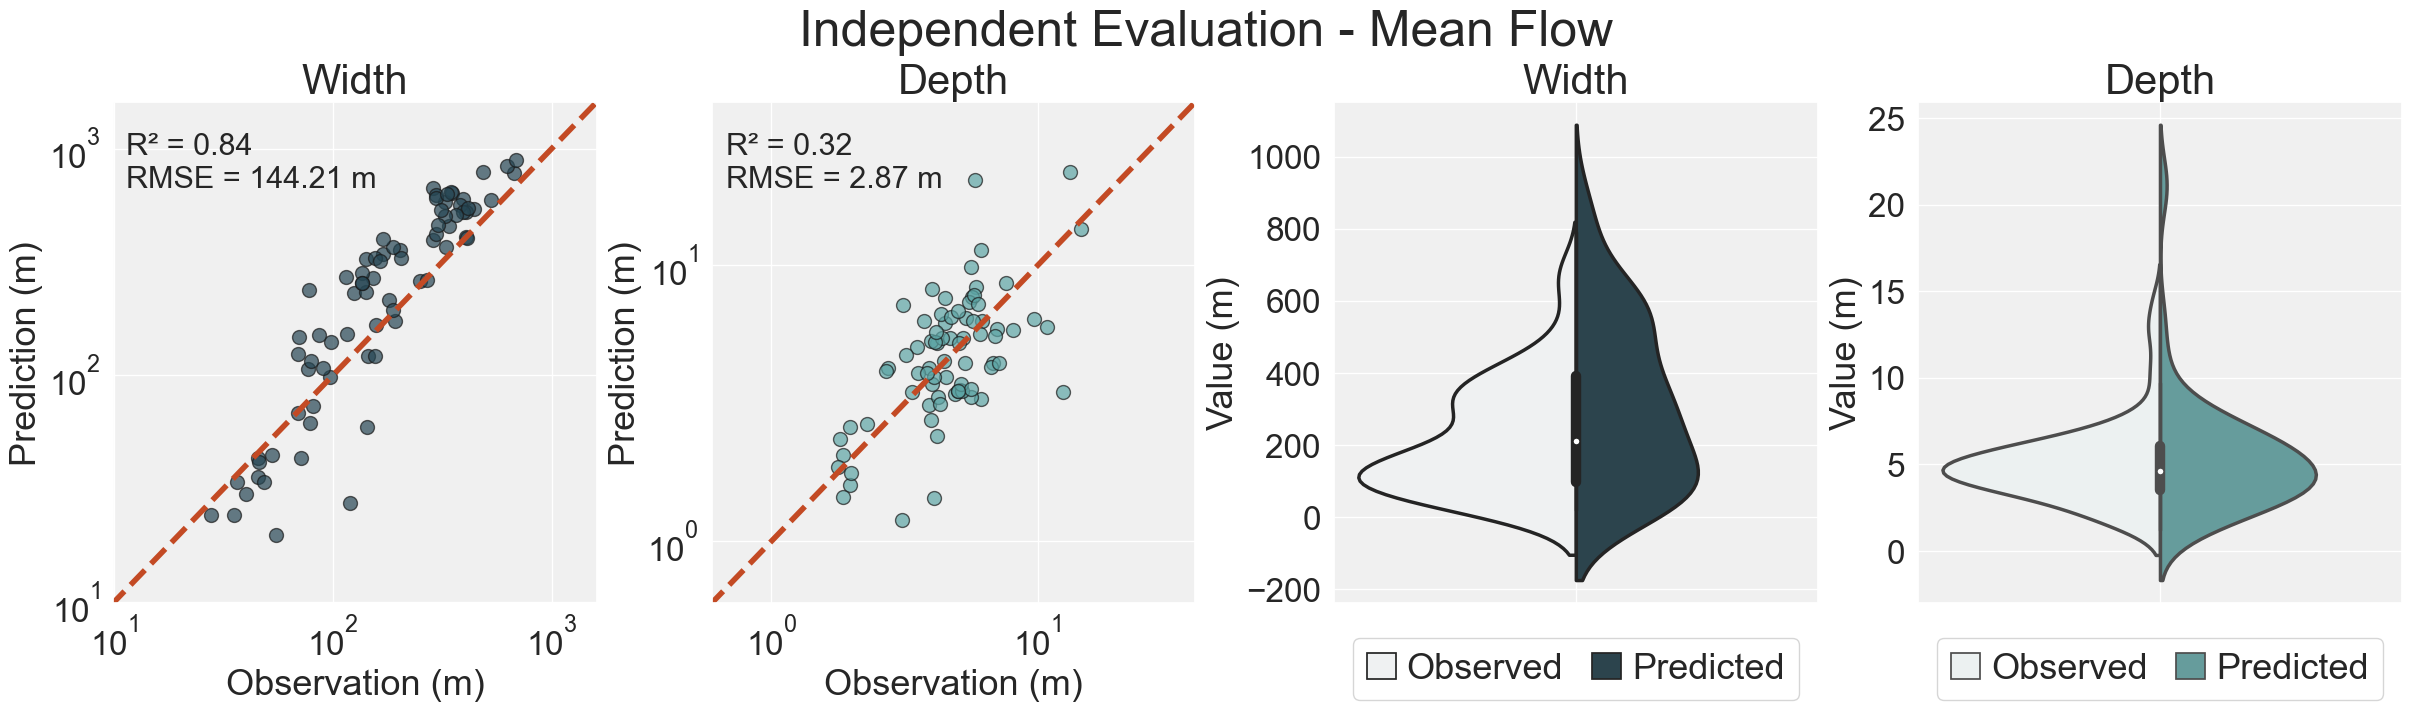

In [8]:
Scatter_Violin_Plots(mf_df_obs_pre['ave_mf_width_obs'], mf_df_obs_pre['ave_mf_width_pre_mlrxgb'], mf_df_obs_pre['ave_mf_depth_obs'], mf_df_obs_pre['ave_mf_depth_pre_mlrxgb'], "Observation (m)", "Prediction (m)",  "Value (m)", "Width", "Depth", "Independent Evaluation - Mean Flow", "R\N{SUPERSCRIPT TWO} = 0.84\nRMSE = 144.21 m", "R\N{SUPERSCRIPT TWO} = 0.32\nRMSE = 2.87 m")